# Simple Convnets using Tensorflow and the MNIST Dataset

In [1]:
import numpy as np
import sys
import tensorflow as tf
import time

import load_mnist

from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(4, 4)

## Fetch and Read In Data

In [2]:
train_im, test_im, train_labels, test_labels = load_mnist.Datasets()

## Throw a random forest at it
Just to get a baseline for a classifier over raw pixel values.

In [93]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(train_im.reshape(60000, 28 * 28), train_labels)
model_labels = clf.predict(test_im.reshape(10000, 28 * 28))
(model_labels == test_labels).mean()

0.96779999999999999

In [94]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

In [95]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

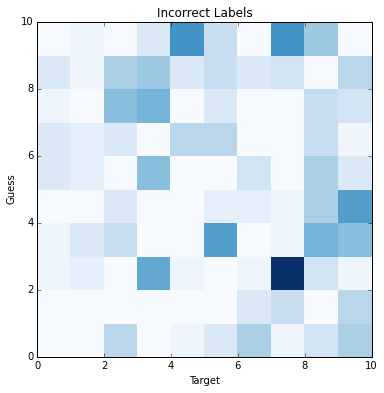

In [96]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Target")
plt.ylabel("Guess")
plt.title("Incorrect Labels")
plt.show()

## Simple softmax regression w/ TensorFlow
To familiarize ourselves with TensorFlow concepts.
Based on the TensorFlow tutorial at http://tensorflow.org/tutorials/mnist/pros/index.md

In [10]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

no existing session to delete


In [11]:
x = tf.placeholder(tf.float32, shape=[None, 28 * 28])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([28 * 28, 10]))
b = tf.Variable(tf.zeros([10]))

sess.run(tf.initialize_all_variables())

In [12]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.0001).minimize(xent)

In [13]:
train_labels_one_hot = np.zeros((60000, 10))
train_labels_one_hot[np.arange(60000), train_labels] = 1
test_labels_one_hot = np.zeros((10000, 10))
test_labels_one_hot[np.arange(10000), test_labels] = 1

In [14]:
batch_size = 1000
epochs = 10
for ep in xrange(epochs):
    print "Starting training epoch {ep}".format(ep=ep)
    for i in xrange(train_im.shape[0] / batch_size):
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset].reshape(batch_size, 28 * 28),
            y_: train_labels_one_hot[start_offset:stop_offset]
        })
    accuracy_expr = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32))
    accuracy = accuracy_expr.eval(feed_dict={
        x: test_im.reshape(10000, 28 * 28),
        y_: test_labels_one_hot})
    print accuracy
    

Starting training epoch 0
0.893
Starting training epoch 1
0.9041
Starting training epoch 2
0.9092
Starting training epoch 3
0.9115
Starting training epoch 4
0.9139
Starting training epoch 5
0.9156
Starting training epoch 6
0.9165
Starting training epoch 7
0.9177
Starting training epoch 8
0.9186
Starting training epoch 9
0.9195


## Simple ConvNet w/ TensorFlow
Still based off of the TensorFlow tutorial. Haven't done much here aside from replace the RELU units with ELUs and fiddle with some training params.

In [21]:
try:
    del(sess)
    print "deleted session"
except Exception as e:
    print "no existing session to delete"
sess = tf.InteractiveSession()

deleted session


In [6]:
def weight_variable(shape, init=0.01):
    initial = tf.random_uniform(shape, minval=-init, maxval=init)
    return tf.Variable(initial, name="weights")

def bias_variable(shape, init=0.01):
    initial = tf.constant(init, shape=shape)
    return tf.Variable(initial, name="bias")

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name="conv")

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME', name="max_pool")

def elu(x):
    pos = tf.cast(tf.greater_equal(x, 0), tf.float32)
    return (pos * x) + ((1 - pos) * (tf.exp(x) - 1))

#### Inputs

In [23]:
x = tf.placeholder(tf.float32, [None, 28, 28])
y_ = tf.placeholder(tf.float32, [None, 10])

#### Internal Structure and Outputs

In [24]:
# Compare elu vs. tf.nnet.relu
nonlin = elu

with tf.name_scope("conv1") as scope:
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = nonlin(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

with tf.name_scope("conv2") as scope:
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = nonlin(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

with tf.name_scope("dense") as scope:
    W_dense = weight_variable([7 * 7 * 64, 1024])
    b_dense = bias_variable([1024])
    h_dense = nonlin(tf.matmul(tf.reshape(h_pool2, [-1, 7 * 7 * 64]), W_dense) + b_dense)

with tf.name_scope("dropout") as scope:
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    h_dropout = tf.nn.dropout(h_dense, keep_prob)

with tf.name_scope("softmax_output") as scope:
    W_out = weight_variable([1024, 10])
    b_out = bias_variable([10])
    y = tf.nn.softmax(tf.matmul(h_dropout, W_out) + b_out)

#### Training, Evaluation, and Initilization

In [25]:
xent = -tf.reduce_mean(y_ * tf.log(y))
train_step = tf.train.AdamOptimizer(0.0001).minimize(xent)
correct = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

sess.run(tf.initialize_all_variables())

#### Main Loop

In [26]:
num_epochs = 10
batch_size = 200
dropout_keep_rate = 0.5
test_every_n_batches = 50

batches_per_epoch = train_im.shape[0] / batch_size
mark = time.time()
for ep in xrange(num_epochs):
    for i in xrange(batches_per_epoch):
        sys.stdout.write(".")
        sys.stdout.flush()
        start_offset = i * batch_size
        stop_offset = start_offset + batch_size
        train_step.run(feed_dict={
            x: train_im[start_offset:stop_offset],
            y_: train_labels_one_hot[start_offset:stop_offset],
            keep_prob: dropout_keep_rate})
        if i % test_every_n_batches == 0:
            ac = accuracy.eval(feed_dict={
                x: test_im[:1000],
                y_: test_labels_one_hot[:1000],
                keep_prob: 1.0})
            print "\nFinished epoch {ep}, batch {ba} after {t:.2f} seconds: accuracy = {ac:.3f}".format(
                ep=ep, ba=i, t=time.time() - mark, ac=ac)
    ac = accuracy.eval(feed_dict={
        x: test_im,
        y_: test_labels_one_hot,
        keep_prob: 1.0})
    print "\nEND OF EPOCH {ep}: accuracy = {ac:.4f}".format(ep=ep, ac=ac)

.
Finished epoch 0, batch 0 after 3.69 seconds: accuracy = 0.433
..................................................
Finished epoch 0, batch 50 after 50.13 seconds: accuracy = 0.900
..................................................
Finished epoch 0, batch 100 after 93.93 seconds: accuracy = 0.935
..................................................
Finished epoch 0, batch 150 after 137.77 seconds: accuracy = 0.958
..................................................
Finished epoch 0, batch 200 after 182.42 seconds: accuracy = 0.967
..................................................
Finished epoch 0, batch 250 after 226.38 seconds: accuracy = 0.972
.................................................
END OF EPOCH 0: accuracy = 0.9747
.
Finished epoch 1, batch 0 after 292.29 seconds: accuracy = 0.973
..................................................
Finished epoch 1, batch 50 after 336.29 seconds: accuracy = 0.977
..................................................
Finished epoch 1, batch 100 a

### Build a random forest based on hidden layer activations
Will a random forest on top of representeations developed by the convolutional network outperform the network itself?

In [27]:
hidden_list = []
for i in xrange(60):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: train_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 1.75 seconds
Batch 1 in 1.70 seconds
Batch 2 in 1.76 seconds
Batch 3 in 1.74 seconds
Batch 4 in 1.80 seconds
Batch 5 in 1.81 seconds
Batch 6 in 1.73 seconds
Batch 7 in 1.79 seconds
Batch 8 in 1.76 seconds
Batch 9 in 1.74 seconds
Batch 10 in 1.73 seconds
Batch 11 in 1.73 seconds
Batch 12 in 1.73 seconds
Batch 13 in 1.76 seconds
Batch 14 in 1.74 seconds
Batch 15 in 1.77 seconds
Batch 16 in 1.76 seconds
Batch 17 in 1.76 seconds
Batch 18 in 1.76 seconds
Batch 19 in 1.74 seconds
Batch 20 in 1.75 seconds
Batch 21 in 1.75 seconds
Batch 22 in 1.78 seconds
Batch 23 in 1.82 seconds
Batch 24 in 1.77 seconds
Batch 25 in 1.74 seconds
Batch 26 in 1.88 seconds
Batch 27 in 1.78 seconds
Batch 28 in 1.76 seconds
Batch 29 in 1.72 seconds
Batch 30 in 1.74 seconds
Batch 31 in 1.74 seconds
Batch 32 in 1.76 seconds
Batch 33 in 1.73 seconds
Batch 34 in 1.78 seconds
Batch 35 in 1.76 seconds
Batch 36 in 1.77 seconds
Batch 37 in 1.73 seconds
Batch 38 in 1.72 seconds
Batch 39 in 1.80 seconds
Batch 40 i

In [28]:
hidden_train = np.array(hidden_list).reshape(60000, 1024)

In [29]:
hidden_list = []
for i in xrange(10):
    mark = time.time()
    hidden_list.append(
        h_dropout.eval(feed_dict={
            keep_prob: 1.0,
            x: test_im[i * 1000:(i + 1) * 1000]}))
    print "Batch {b} in {t:.2f} seconds".format(b=i, t=time.time() - mark)

Batch 0 in 1.71 seconds
Batch 1 in 1.69 seconds
Batch 2 in 1.75 seconds
Batch 3 in 1.70 seconds
Batch 4 in 1.75 seconds
Batch 5 in 1.77 seconds
Batch 6 in 1.73 seconds
Batch 7 in 1.74 seconds
Batch 8 in 1.74 seconds
Batch 9 in 1.73 seconds


In [30]:
hidden_test = np.array(hidden_list).reshape(10000, 1024)

In [31]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1)
clf.fit(hidden_train, train_labels)
model_labels = clf.predict(hidden_test)
(model_labels == test_labels).mean()

0.99209999999999998

In [32]:
misses = test_im[(model_labels != test_labels)]
miss_test_labels = test_labels[(model_labels != test_labels)]
miss_guess_labels = model_labels[(model_labels != test_labels)]

#### Example Mis-Classified Digits

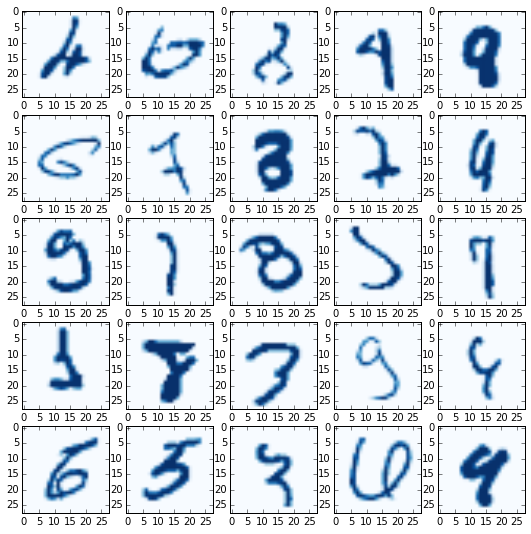

In [33]:
figsize(9, 9)
_, axes = plt.subplots(5, 5)
axes = axes.reshape(25)

for x in xrange(25):
    im = misses[x]
    test_label = miss_test_labels[x]
    guess_label = miss_guess_labels[x]
    ax = axes[x]
    ax.imshow(im, cmap=cm.Blues)
plt.show()

In [34]:
confusion = np.zeros((10, 10), dtype=np.int)
for guess, target in zip(miss_guess_labels, miss_test_labels):
    confusion[guess, target] += 1

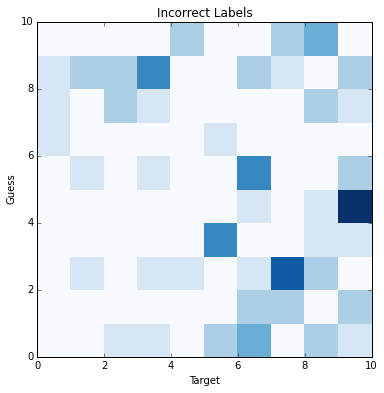

In [35]:
figsize(6, 6)
plt.pcolor(confusion, cmap=cm.Blues)
plt.xlabel("Target")
plt.ylabel("Guess")
plt.title("Incorrect Labels")
plt.show()